In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import pandas as pd

In [2]:
import functions
from SA_VQE import SA_VQE_expec_val

Mode A: Quick testing

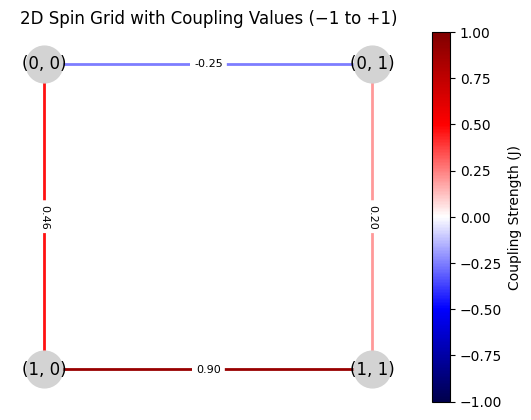

In [3]:
# Set the number of qubits in each row/column of the square grid
dim_grid = (2,2)
num_qubits = dim_grid[0]*dim_grid[1]

# Generate the coupling coefficients
seed = 42
J_right, J_down = functions.generate_couplings(dim_grid, seed)
functions.visualize_couplings(dim_grid, J_right, J_down)


In [ ]:
# Obtain the Hamiltonian (qml.Hamiltonian) of the 2D Antiferromagnetic lattice
hamiltonian = functions.hamiltonian(dim_grid, J_right, J_down)

# Define the observable by its name and the qubits it affects
# Options: obs_name = 'correlation', qubits = (q0, q1)
obs_name = 'correlation'

correlations_matrix_diag = np.zeros((num_qubits, num_qubits))
correlations_matrix_SA_VQE = np.zeros((num_qubits, num_qubits))

qubits = [(i,j) for i in range(dim_grid[0]) for j in range(dim_grid[1])]

for i, q0 in enumerate(qubits):
    for j, q1 in enumerate(qubits[i+1:], start=i+1):

        obs = functions.observable(dim_grid, obs_name, (q0, q1))

        # Obtain ground state property by diagonalization
        obs_diag, _, ground_state_energy_diag = functions.ground_state_expectation_value(dim_grid, hamiltonian, obs)
        correlations_matrix_diag[i, j] = obs_diag
        correlations_matrix_diag[j, i] = obs_diag
        
        # Obtain ground state property by VQE

        # Hyperparameters
        depth = 3
        opt_steps = 500
        learning_rate = 0.01

        # Obtain expectation value of the observable in the ground state, as well as the ground state energy
        obs_SA_VQE, _, ground_state_energy_VQE = SA_VQE_expec_val(dim_grid, hamiltonian, obs, depth, opt_steps, learning_rate)
        correlations_matrix_SA_VQE[i, j] = obs_SA_VQE
        correlations_matrix_SA_VQE[j, i] = obs_SA_VQE

# Plot the heatmaps of the 2-qubit correlation for diagonalization and VQE methods
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

im1 = axs[0].imshow(correlations_matrix_diag, cmap='viridis', vmin=np.min(correlations_matrix_diag), vmax=np.max(correlations_matrix_diag))
axs[0].set_title("Correlation (Diagonalization)")
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(correlations_matrix_SA_VQE, cmap='viridis', vmin=np.min(correlations_matrix_SA_VQE), vmax=np.max(correlations_matrix_SA_VQE))
axs[1].set_title("Correlation (SA VQE)")
plt.colorbar(im2, ax=axs[1])

for ax in axs:
    ax.set_xlabel("Qubit index")
    ax.set_ylabel("Qubit index")
    ax.set_xticks(range(num_qubits))
    ax.set_yticks(range(num_qubits))

plt.tight_layout()
plt.show()

Mode B: Generating data sets

In [3]:
%%time

# General parameters
dim_grid = (2,2)
obs_name = 'correlation'
qubits = ((0,0), (0,1))

# Training parameters
num_examples = 100
mode = 'fourier'

# VQE parameters
depth = 3
opt_steps = 500
learning_rate = 0.01

# Random fourier map parameters
delta = 1
gamma = 0.6
R = 10

# Generate datasets and perform feature mapping of the inputs
X, PhiX_quantum_diag, PhiX_quantum_VQE, PhiX_fourier, Y_diag, Y_VQE = functions.generate_training_set(dim_grid, num_examples, obs_name, qubits, depth=depth, opt_steps=opt_steps, learning_rate=learning_rate, delta=delta, gamma = gamma, R=R)
print("\nData set generated")


Data set generated
CPU times: total: 1h 6min 8s
Wall time: 4h 8min 19s


Mode C: Training and test performance of different ML methods

In [6]:
# 1. Neural network
# Train the model with neural network

print('\nNeural Network [output obtained by diagonalization]:\n')
functions.neural_network(X, Y_diag)
print('\nNeural Network [output obtained by VQE]:\n')
functions.neural_network(X, Y_VQE)

    


Neural Network [output obtained by diagonalization]:



ValueError: Cannot convert '4' to a shape.

ROUND 1

In [8]:
# 2. LASSO regression without feature map

coefficients, L1_norm_coef, optimal_alpha, train_mse, test_mse, train_r2, test_r2 = functions.lasso_regression(X, Y_diag)
print('\nLASSO without feature map')
print(f'Coefficients (omega)= {coefficients}')
print(f'L1 norm of omega = {L1_norm_coef}')
print(f"Optimal alpha: {optimal_alpha}")
print(f'MSE: training -> {train_mse}; test -> {test_mse}')
print(f'R^2: training -> {train_r2}; test -> {test_r2}')


LASSO without feature map
Coefficients (omega)= [-0.7894112  -0.06121879  0.08806352  0.09262375]
L1 norm of omega = 1.0313172657566838
Optimal alpha: 0.001
MSE: training -> 0.09198885643930219; test -> 0.055568696922839556
R^2: training -> 0.6783591143556081; test -> 0.7454908440196886


In [9]:
# 3. LASSO regression with quantum feature map

print("With diagonalization")
coefficients, L1_norm_coef, optimal_alpha, train_mse, test_mse, train_r2, test_r2 = functions.lasso_regression(PhiX_quantum_diag, Y_diag)
print('\nLASSO with quantum feature map')
print(f'Coefficients (omega)= {coefficients}')
print(f'L1 norm of omega = {L1_norm_coef}')
print(f"Optimal alpha: {optimal_alpha}")
print(f'MSE: training -> {train_mse}; test -> {test_mse}')
print(f'R^2: training -> {train_r2}; test -> {test_r2}')

print("With VQE")
coefficients, L1_norm_coef, optimal_alpha, train_mse, test_mse, train_r2, test_r2 = functions.lasso_regression(PhiX_quantum_VQE, Y_VQE)
print('\nLASSO with quantum feature map')
print(f'Coefficients (omega)= {coefficients}')
print(f'L1 norm of omega = {L1_norm_coef}')
print(f"Optimal alpha: {optimal_alpha}")
print(f'MSE: training -> {train_mse}; test -> {test_mse}')
print(f'R^2: training -> {train_r2}; test -> {test_r2}')


With diagonalization

LASSO with quantum feature map
Coefficients (omega)= [0.66518909 0.00131689 0.33356246]
L1 norm of omega = 1.0000684371554256
Optimal alpha: 0.0001
MSE: training -> 6.621617043853006e-06; test -> 0.007722652407883087
R^2: training -> 0.9999768473829024; test -> 0.9646296232393421
With VQE

LASSO with quantum feature map
Coefficients (omega)= [0.33324994 0.33319726 0.33325905]
L1 norm of omega = 0.9997062538366528
Optimal alpha: 0.0001
MSE: training -> 3.0689307660655324e-08; test -> 2.632294651675043e-08
R^2: training -> 0.9999999126525284; test -> 0.9999999136628629


In [10]:
# 4. LASSO regression with random Fourier Feature map
coefficients, L1_norm_coef, optimal_alpha, train_mse, test_mse, train_r2, test_r2 = functions.lasso_regression(PhiX_fourier, Y_diag)
print('\nLASSO with random Fourier feature map')
print(f'Coefficients (omega)= {coefficients}')
print(f'L1 norm of omega = {L1_norm_coef}')
print(f"Optimal alpha: {optimal_alpha}")
print(f'MSE: training -> {train_mse}; test -> {test_mse}')
print(f'R^2: training -> {train_r2}; test -> {test_r2}')


LASSO with random Fourier feature map
Coefficients (omega)= [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.37248798e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.68596195e-01 -1.71414093e-02
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.08040196e-01
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -7.09733332e-03
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.32656058e-01
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e

c:\Users\César Hernando\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.086e-03, tolerance: 1.880e-03
  model = cd_fast.enet_coordinate_descent(


In [17]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf

In [32]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras import regularizers

def neural_network(X, y):
    '''
    Trains a feedforward neural network on the provided dataset, with regularization,
    early stopping, and plots of training vs validation loss.

    Inputs:
    -------
    X : np.ndarray
        Input features
    y : np.ndarray
        Target values
    '''

    # Split dataset: 80% train, 10% val, 10% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    dim_input = X.shape[1]
    num_examples = X_train.shape[0]

    # Set seed for reproducibility
    seed = 42
    tf.random.set_seed(seed)

    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(dim_input,)),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(1, activation=None)
    ])

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(optimizer=opt, loss='mse')

    # Early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=max(1, int(num_examples / 5)),
        epochs=100,
        callbacks=[early_stop],
        verbose=0
    )

    # Evaluate on test data
    output = model.predict(X_test)
    print(f"r2 score on test data = {r2_score(y_test, output):.4f}")
    print(f"Mean squared error on test data = {mean_squared_error(y_test, output):.4f}")

    # Plot training vs validation loss
    plt.figure(figsize=(7, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




Neural Network [output obtained by diagonalization]:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
r2 score on test data = 0.7135
Mean squared error on test data = 0.0564


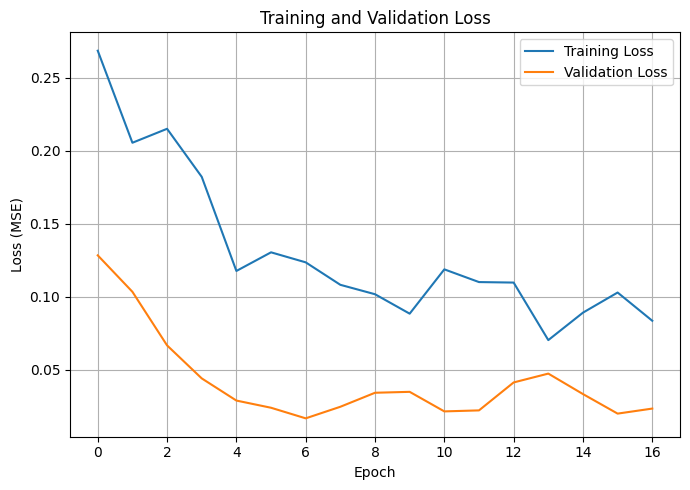


Neural Network [output obtained by VQE]:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
r2 score on test data = 0.9706
Mean squared error on test data = 0.0072


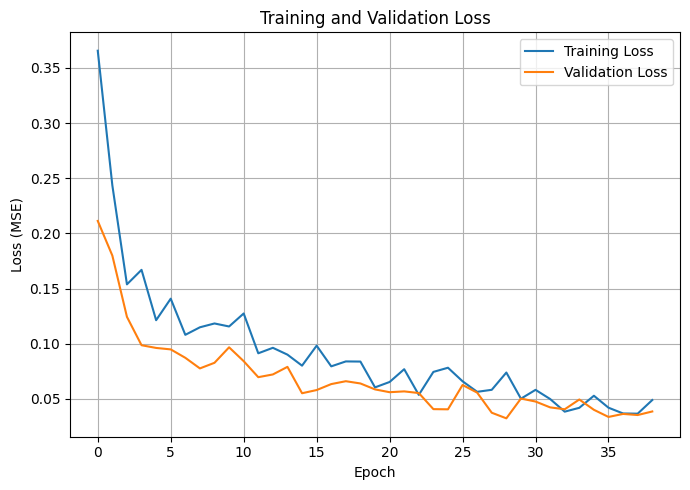

In [33]:
# 1. Neural network
# Train the model with neural network

print('\nNeural Network [output obtained by diagonalization]:\n')
neural_network(X, Y_diag)
print('\nNeural Network [output obtained by VQE]:\n')
neural_network(X, Y_VQE)